# Fooled by Neural Noise
This code contains a Monte Carlo simulation of running many experiments under the null being true, but adding a circular analysis that leads to significant results.
Additional code for generating images is present.

In [2]:
# import libraries
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# set parameters
ALPHA = 0.01

Display multivariate Gaussian, 0 covariance.

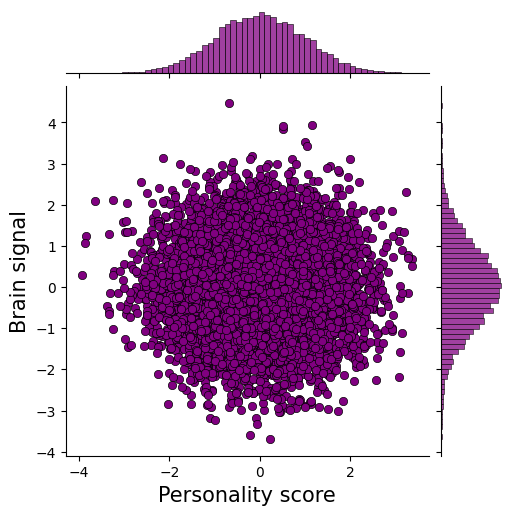

In [106]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters
df = 2/3  # Degrees of freedom
rho = 0  # Correlation coefficient

# Generate random samples
mean = [0, 0]  # Mean vector
cov = [[1, rho], [rho, 1]]  # Covariance matrix
samples = np.random.multivariate_normal(mean, cov, size=10000)

# Scatter plot of the samples
sns.jointplot(x=samples[:, 0], y=samples[:, 1], height = 5, color='purple', edgecolor='black')
plt.xlabel('Personality score', size = 15)
plt.ylabel('Brain signal', size = 15)
# plt.title('Bivariate Gaussian with 0 covariance')
plt.grid(False)
plt.show()

## Function to replicate a single experiment

In [116]:
def run_experiment(n_subjects: int = 10, n_voxels: int = 10000, alpha: float = 0.01, pos_corr_threshold: float = 0):
  """
  Run an experiment to calculate correlations between voxel activations and personality scores.

  :param n_subjects: number of subjects, defaults to 10
  :type n_subjects: int, optional
  :param n_voxels: number of voxels, defaults to 10000
  :type n_voxels: int, optional
  :param alpha: significance threshold, defaults to 0.01
  :type alpha: float, optional
  :param pos_corr_threshold: correlation threshold (positive), defaults to 0
  :type pos_corr_threshold: float, optional
  :return: A list containing the following elements:
             - final_corr (float): Correlation between average voxel activations and personality scores.
             - final_pval (float): p-value associated with final_corr.
             - final_corr_circular (float): Correlation between average significant voxel activations and personality scores.
             - final_pval_circular (float): p-value associated with final_corr_circular.
             - pc_significant (float): Proportion of significant positive correlations.
             - personality (numpy.ndarray): Array of random personality test scores.
             - avg_voxel_activation (numpy.ndarray): Average voxel activations across all voxels.
             - avg_voxel_activation_circular (numpy.ndarray): Average voxel activations of significant voxels only.

  :rtype: List[Union[float, np.ndarray]]

  :note:
      If there are no significant positive correlations, NaN values are returned for all elements.

  """
  
  # generate random personality test scores
  personality = np.random.normal(0, 1, n_subjects)

  # generate random voxel activations
  voxel_activations = np.random.normal(0, 2, size=(n_voxels, n_subjects))

  # calculate correlations and p-values
  correlations = np.zeros(n_voxels)
  pvals = np.zeros(n_voxels)
  for i in range(n_voxels):
    correlations[i], pvals[i] = scipy.stats.pearsonr(voxel_activations[i], personality)

  # apply the thresholding and count significant correlations
  mask = (correlations > pos_corr_threshold) & (pvals < alpha)

  # return nan in case of no significant pos correlations
  if np.count_nonzero(mask) == 0:
    return [np.nan] * 8

  # average across significant voxels
  avg_voxel_activation = np.mean(voxel_activations, axis=0)
  avg_voxel_activation_circular = np.mean(voxel_activations[mask], axis=0)

  # run correlation between personality measure and average significant voxel activations
  final_corr, final_pval = scipy.stats.pearsonr(avg_voxel_activation, personality)
  final_corr_circular, final_pval_circular = scipy.stats.pearsonr(avg_voxel_activation_circular, personality)
  pc_significant = np.count_nonzero(mask) / n_voxels

  return [final_corr, final_pval, final_corr_circular, final_pval_circular, pc_significant, personality, avg_voxel_activation, avg_voxel_activation_circular]


In [63]:
final_corr, final_pval, final_corr_circular, final_pval_circular, pc_significant, personality, avg_voxel_activation, avg_voxel_activation_circular = run_experiment(
    n_subjects = 10, n_voxels = 10000, alpha = 0.01, pos_corr_threshold = 0)

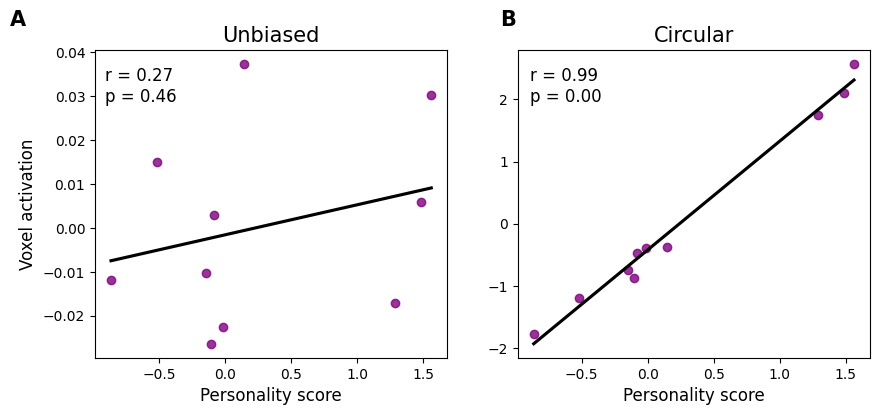

In [64]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.regplot(x = personality, y= avg_voxel_activation, ci=False, ax=ax1, color= 'purple', line_kws={'color': 'black'})
sns.regplot(x = personality, y= avg_voxel_activation_circular, ci=False, ax=ax2, color= 'purple', line_kws={'color': 'black'})
ax1.set_title(f"Unbiased", size = 15)
ax2.set_title(f"Circular", size = 15)
ax1.set_xlabel("Personality score", size = 12)
ax2.set_xlabel("Personality score", size = 12)
ax1.set_ylabel("Voxel activation", size = 12)

fig.text(0.04, 0.94, f'A', fontsize=15, fontweight='bold')
fig.text(0.53, 0.94, f'B', fontsize=15, fontweight='bold')

fig.text(0.135, 0.75, f"r = {final_corr:.2f}\np = {final_pval:.2f}", fontsize=12)
fig.text(0.56, 0.75, f"r = {final_corr_circular:.2f}\np = {final_pval_circular:.2f}", fontsize=12)


plt.show(fig)

## Run Monte Carlo simulation

In [74]:
def run_simulations(n_simulations: int = 1000, n_subjects: int = 10, n_voxels: int = 10000, alpha: float = 0.01, pos_corr_threshold: float = 0) -> pd.DataFrame:
    """
    Run simulations to collect results from multiple experiments.

    :param n_simulations: Number of simulations to run. Default is 1000.
    :type n_simulations: int
    :param n_subjects: Number of subjects per simulation. Default is 10.
    :type n_subjects: int
    :param n_voxels: Number of voxels per simulation. Default is 10000.
    :type n_voxels: int
    :param alpha: Significance threshold (p-value) for correlation tests. Default is 0.01.
    :type alpha: float
    :param pos_corr_threshold: Positive correlation threshold. Default is 0.
    :type pos_corr_threshold: float

    :return: A DataFrame containing the results from the simulations, with the following columns:
             - 'exp_number' (int): Experiment number.
             - 'final_corr' (float): Correlation between average voxel activations and personality scores.
             - 'final_pval' (float): p-value associated with final_corr.
             - 'final_corr_circular' (float): Correlation between average significant voxel activations and personality scores.
             - 'final_pval_circular' (float): p-value associated with final_corr_circular.
             - 'pc_significant' (float): Proportion of significant positive correlations.

    :rtype: pandas.DataFrame
    """
    simulation_results_array = np.empty((n_simulations, 6))
    
    for exp_number in tqdm(range(n_simulations), total = n_simulations):
        final_corr, final_pval, final_corr_circular, final_pval_circular, pc_significant, _, _, _ = run_experiment(n_subjects=n_subjects, n_voxels=n_voxels, alpha=alpha, pos_corr_threshold=pos_corr_threshold)
        
        simulation_results_array[exp_number, 0] = exp_number
        simulation_results_array[exp_number, 1] = final_corr
        simulation_results_array[exp_number, 2] = final_pval
        simulation_results_array[exp_number, 3] = final_corr_circular
        simulation_results_array[exp_number, 4] = final_pval_circular
        simulation_results_array[exp_number, 5] = pc_significant

    columns = ['exp_number', 'final_corr', 'final_pval', 'final_corr_circular', 'final_pval_circular', 'pc_significant']
    simulation_results_df = pd.DataFrame(simulation_results_array, columns=columns)

    return simulation_results_df

In [117]:
df_results = run_simulations(
    n_simulations = 1000,
    n_subjects = 10,
    n_voxels = 1000,
    alpha = ALPHA)

## Plot correlations

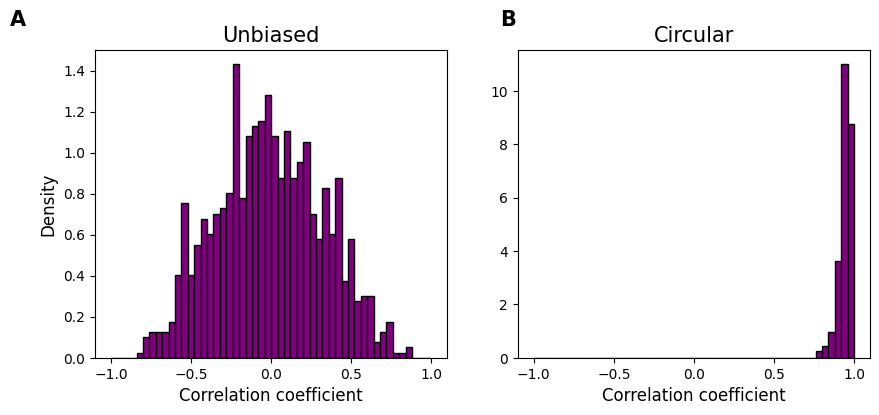

In [122]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

df_results.final_corr.hist(bins = 50, grid = False, density = True, range=[-1, 1], ax=ax1, color='purple', edgecolor='black')
df_results.final_corr_circular.hist(bins = 50, grid = False, density = True, range=[-1, 1], ax=ax2, color='purple', edgecolor='black')
ax1.set_title(f"Unbiased", size = 15)
ax2.set_title(f"Circular", size = 15)
ax1.set_xlabel("Correlation coefficient", size = 12)
ax2.set_xlabel("Correlation coefficient", size = 12)
ax1.set_ylabel("Density", size = 12)

fig.text(0.04, 0.94, f'A', fontsize=15, fontweight='bold')
fig.text(0.53, 0.94, f'B', fontsize=15, fontweight='bold')

plt.show(fig)

## Plot <i>p</i>-values

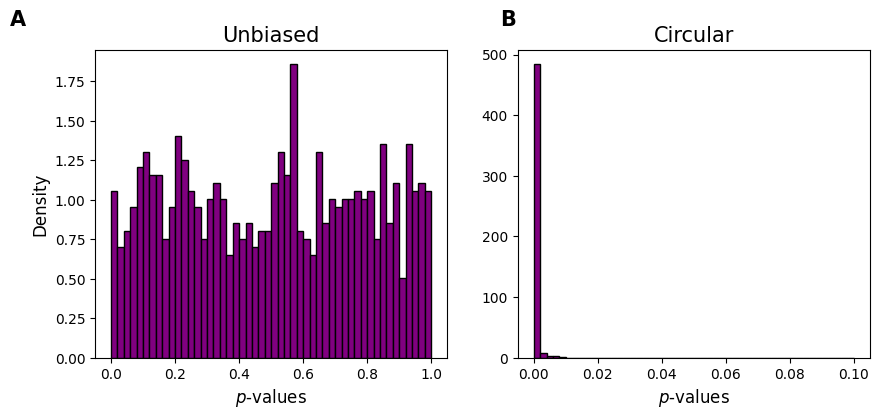

In [125]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

df_results.final_pval.hist(bins = 50, grid = False, density = True, range=[0, 1], ax=ax1, color='purple', edgecolor='black')
df_results.final_pval_circular.hist(bins = 50, grid = False, density = True, range=[0, 0.1], ax=ax2, color='purple', edgecolor='black')
ax1.set_title(f"Unbiased", size = 15)
ax2.set_title(f"Circular", size = 15)
ax1.set_xlabel("$\it{p}$-values", size = 12)
ax2.set_xlabel("$\it{p}$-values", size = 12)
ax1.set_ylabel("Density", size = 12)

fig.text(0.04, 0.94, f'A', fontsize=15, fontweight='bold')
fig.text(0.53, 0.94, f'B', fontsize=15, fontweight='bold')

plt.show(fig)

Expected proportion of significan results: 0.005


Text(0.5, 0, '% of significant correlations')

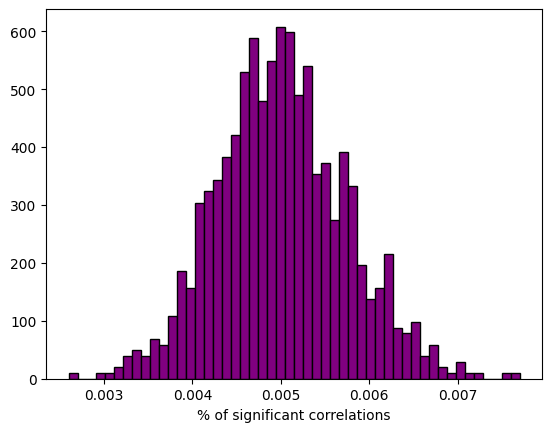

In [99]:
print(f"Expected proportion of significan results: {ALPHA/2}")
df_results.pc_significant.hist(bins = 50, grid = False, density=True, color='purple', edgecolor='black');
plt.xlabel("% of significant correlations")

That's all folks!

--------